# Seq2Seq(Sequence to Sequence)
- 어떠한 순차데이터가 들어가면 순차데이터를 출력해주는 구조
- 인코더와 디코더로 구성된 모형
- 인코더는 입력 시퀀스를 처리
- 디코더는 인코더로부터 넘겨 받은 정보로 부터 자연어를 생성

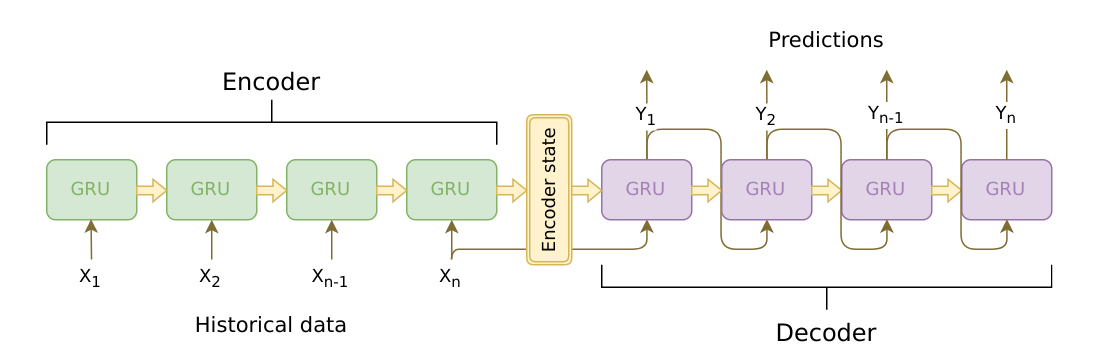

## 번역에서 순환신경망 구조의 문제점
- 번역에 경우 인코더 단어와 디코더 단어에 대응되는 부분이 있다
- 순환신경망은 순차적으로 간접적인 정보가 전달되므로 비효율적

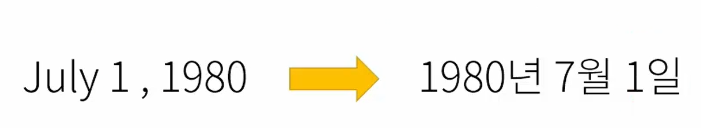

## 주의 메커니즘(attention mechanism)
- 인코더에서 디코더에 필요한 정보를 가져오는 방법


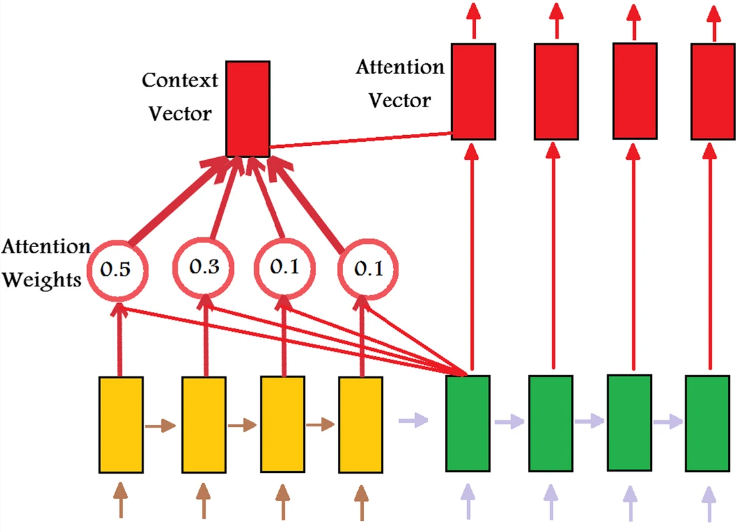

# 트랜스포머(Transformer)
- attention mechanism 만을 사용한 Seq2Seq 모델
- 순환신경망을 제외하고 구현된 모델
- 인코더 내에서 attention mechanism 적용
- 디코더 내에서 attention mechanism 적용
- 인코더와 디코더 사이에서 attention mechanism 적용

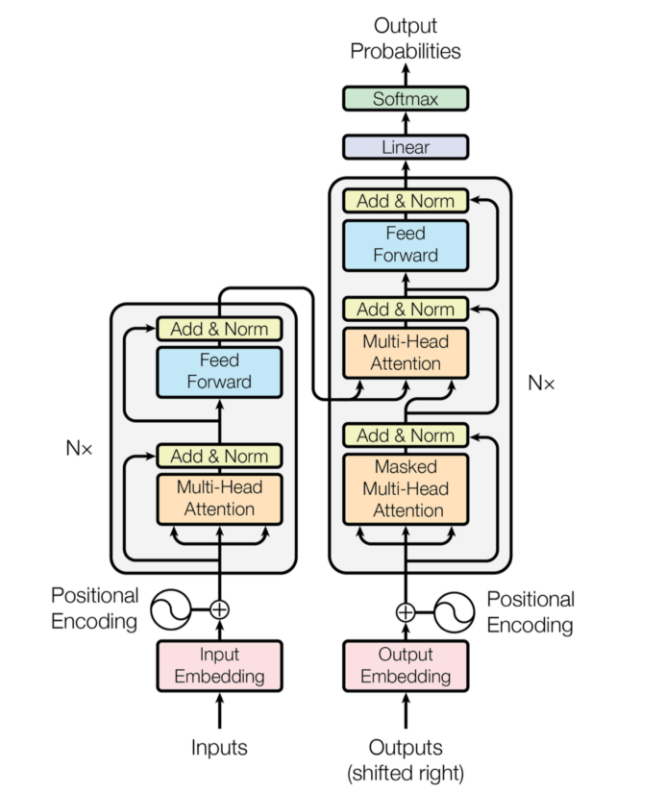

# 구글 드라이브 연결

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import pandas as pd
import numpy as np
import torch
from tqdm.auto import tqdm
import random # 시드 고정을 위해
import os # 시드 고정을 위해

In [23]:
def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)    # 파이썬 환경변수 시드 고정
    np.random.seed(seed)
    torch.manual_seed(seed) # cpu 연산 무작위 고정
    torch.cuda.manual_seed(seed) # gpu 연산 무작위 고정
    torch.backends.cudnn.deterministic = True  # cuda 라이브러리에서 Deterministic(결정론적)으로 예측하기 (예측에 대한 불확실성 제거 )

# 데이터 경로를 변경하시오

In [36]:
DATA_PATH = "/content/drive/MyDrive/01-python/data/"
SEED = 42
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [38]:
df = pd.read_csv(f"{DATA_PATH}naver_review_train (1).csv")

In [39]:
!pip install kiwipiepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 2.0 MB/s 
     |████████████████████████████████| 30.5 MB 2.5 MB/s 
  Created wheel for kiwipiepy-model: filename=kiwipiepy_model-0.14.0-py3-none-any.whl size=30560039 sha256=0ab086dd4d4a4f4017770fcd9f8c39b702ac772449f029d1942bf96670558a1d
  Stored in directory: /root/.cache/pip/wheels/97/36/50/1fc99e4a3ce636ed30739cc2cb333b36e6e3778f365f1adf77
Successfully built kiwipiepy-model


In [40]:
from kiwipiepy import Kiwi
kiwi = Kiwi()
kiwi.prepare() # prepare 분석 준비 완료

In [64]:
df = df.dropna().reset_index(drop=True)

In [65]:
text = df["document"][0]


In [76]:
lst = df["document"].tolist()
gen = kiwi.analyze(lst)
train_lst = []

for tokens in tqdm(gen,total=len(lst)): # total 제너레이터의 길이를 알수있다
    token = [token.form for token in tokens[0][0] if token.tag[0] in "NVJ"]
    train_lst.append(token)

  0%|          | 0/149995 [00:00<?, ?it/s]

In [78]:
len(train_lst)

149995

In [9]:
# #형태소 분석 라이브러리
# import spacy 
# nlp = spacy.load("en_core_web_sm") 

# # 토크나이저
# def get_tokenizer(nlp,text):
#     doc = nlp(text) 
#     return [ token.lemma_ for token in doc if token.tag_[0] in "NVJ" ]

# # build_vocab_from_iterator에 넣을 제너레이터
# def yield_tokens(data,tokenizer,nlp): 
#     for text in data: 
#         yield tokenizer(nlp,text) 
# # 어휘집 생성
# from torchtext.vocab import build_vocab_from_iterator 
# gen = yield_tokens(df["review"].str.lower(),get_tokenizer,nlp)
# vocab = build_vocab_from_iterator(gen, specials=["<pad>","<unk>"]) 
# vocab.set_default_index(vocab["<unk>"])


# # 학습데이터및 정답데이터 생성
# train = [ vocab(text) for text in df.review.tolist() ] 
# target = df.sentiment.to_numpy().reshape(-1,1) 

# # 패딩 처리
# max_len = max(len(lst) for lst in train)
# train = [lst + [0] * (max_len - len(lst))  if len(lst) < max_len else lst for lst in train ]
# train = np.array(train)

In [79]:
# 어휘집
from torchtext.vocab import build_vocab_from_iterator
vocab = build_vocab_from_iterator(train_lst, specials=["<pad>","<unk>"]) 
vocab.set_default_index(vocab["<unk>"])

In [80]:
len(vocab)

42830

# 학습 정답 데이터

In [117]:
train = [vocab(tokens) for tokens in  train_lst]
target = df.label.to_numpy().reshape(-1,1) 
len(train) , target.shape

(149995, (149995, 1))

# 패딩

In [118]:
max_len = max(len(lst) for lst in train)
train = [lst + [0] * (max_len - len(lst))  if len(lst) < max_len else lst for lst in train ]
train = np.array(train)
train.shape

(149995, 72)

In [119]:
max_len

72

In [138]:
class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self , x, y = None , max_len = 72 ): # 원래 300
        self.x = x
        self.y = y
        self.max_len = max_len
    def __len__(self): 
        return len(self.x)
    def __getitem__(self, idx): 
        item = {}
        item["x"] = torch.LongTensor(self.x[idx,:self.max_len]) 
        if self.y is not None:
            item["y"] = torch.Tensor(self.y[idx]) 
        return item

In [121]:
dt = ReviewDataset(train,target,max_len)
dl = torch.utils.data.DataLoader(dt, batch_size=2 , shuffle=False)
batch = next(iter(dl))
batch["x"]

tensor([[ 346,  138,   12,  469,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 321,    4,  434,    3,   90, 1078,   34,  533,  478,   31,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])

## torch.nn.TransformerEncoderLayer
- d_model
    - 입력에 들어오는 피쳐 수
- nhead
    - head 개수
- dim_feedforward
    - 피드포워드 부분에 중간 은닉층에 피쳐 수
    - 기본값 : 2048
- batch_first
    - True 이면 (batch,seq,feature)
    - 기본값 : False

## torch.nn.TransformerEncoder
- encoder_layer
    - 인코더 레이어 객체를 넣는다.
- num_layers
    - 인코더 레이어를 얼마나 쌓을 것인가에 대한 개수

In [122]:
embedding_dim = 256
emb_layer = torch.nn.Embedding(len(vocab),embedding_dim)

pos_emb_layer = torch.nn.Embedding(max_len,embedding_dim) # 위치정보반영

encoder_layer = torch.nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=8,dim_feedforward=2048,batch_first=True)
transformer_encoder = torch.nn.TransformerEncoder(encoder_layer, num_layers=6)


x = emb_layer(batch["x"]) 
pos = torch.arange(max_len)
pos = pos_emb_layer(pos) 
x = x + pos 
transformer_encoder(x).shape

torch.Size([2, 72, 256])

# 모델

In [164]:
class Net(torch.nn.Module):
    def __init__(self, vocab_size,max_len , embedding_dim=512,nhead = 8, dim_feedforward = 2048,num_layers=6, device = "cpu"):  
        super().__init__()
        self.emb_layer = torch.nn.Embedding(vocab_size,embedding_dim) 
        self.pos_emb_layer = torch.nn.Embedding(max_len,embedding_dim)

        self.encoder_layer = torch.nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=nhead,dim_feedforward=dim_feedforward,batch_first=True)
        self.transformer_encoder = torch.nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.flatten = torch.nn.Flatten()
        self.dropout = torch.nn.Dropout(0.5)
        self.output_layer = torch.nn.Linear(max_len * embedding_dim, 1)

        self.pos = torch.arange(max_len).to(device) # max_len위치 정보를 반영해줄 정수 시퀀스

    def forward(self, x):
        x = self.emb_layer(x)
        pos = self.pos_emb_layer(self.pos) 
        x = torch.add(x,pos) 
        x = self.transformer_encoder(x)
        x = self.flatten(x)
        x = self.dropout(x) 
        x = self.output_layer(x) 
        return x

# 모델 테스트

In [157]:
model = Net(len(vocab),max_len,embedding_dim=512)
model(batch["x"]).shape

torch.Size([2, 1])

In [158]:
def train_loop(dataloader,model,loss_fn,optimizer,device):
    epoch_loss = 0 
    model.train() 
    for batch in dataloader: 
        pred = model(batch["x"].to(device)) 
        loss = loss_fn(pred, batch["y"].to(device)) 
        
        optimizer.zero_grad() 
        loss.backward()  
        optimizer.step() 
        
        epoch_loss += loss.item() 

    epoch_loss /= len(dataloader) 

    return epoch_loss

In [159]:
@torch.no_grad() 
def test_loop(dataloader,model,loss_fn,device): 
    epoch_loss = 0
    model.eval() 

    pred_list = []
    sig = torch.nn.Sigmoid()

    for batch in dataloader:
        
        pred = model(batch["x"].to(device))
        if batch.get("y") is not None: 
            loss = loss_fn(pred, batch["y"].to(device))
            epoch_loss += loss.item()
        
        pred = sig(pred)
        pred = pred.to("cpu").numpy() 
        pred_list.append(pred)

    epoch_loss /= len(dataloader)

    pred = np.concatenate(pred_list) 
    return epoch_loss , pred 

# 하이퍼 파라미터

In [160]:
n_splits = 2
vocab_size = len(vocab)  
max_len = 72 
embedding_dim = 128 
nhead = 8 
dim_feedforward = 1024 
num_layers = 1 
batch_size = 2
epochs = 10
loss_fn = torch.nn.BCEWithLogitsLoss()

# CV 및 평가지표

In [161]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
cv = KFold(n_splits=n_splits,shuffle=True, random_state=SEED)

In [162]:
train.shape , target.shape ,max_len

((149995, 72), (149995, 1), 72)

# 학습

In [165]:
is_holdout = False
reset_seeds(SEED)
best_score_list = []
for i,(tri,vai) in enumerate(cv.split(train)):
    model = Net(vocab_size,max_len, embedding_dim,nhead,dim_feedforward,num_layers,device).to(device)
    optimizer = torch.optim.Adam(model.parameters())
    
    train_dt = ReviewDataset(train[tri],target[tri],max_len) 
    valid_dt = ReviewDataset(train[vai],target[vai],max_len)
    train_dl = torch.utils.data.DataLoader(train_dt, batch_size=batch_size, shuffle=True)
    valid_dl = torch.utils.data.DataLoader(valid_dt, batch_size=batch_size,shuffle=False)

    best_score = 0
    patience = 0

    for epoch in tqdm(range(epochs)):
        
        train_loss = train_loop(train_dl, model, loss_fn,optimizer,device )
        valid_loss , pred = test_loop(valid_dl, model, loss_fn,device  )
        pred = (pred > 0.5).astype(int) 

        score = accuracy_score(target[vai],pred )
        patience += 1
        if best_score < score:
            patience = 0
            best_score = score
            torch.save(model.state_dict(),f"model_{i}.pth")

        if patience == 10:
            break
    print(f"Fold ({i}), BEST ACC: {best_score}")
    best_score_list.append(best_score)

    if is_holdout:
        break
np.mean(best_score_list)

  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: ignored